<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/AE_simplest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import glob
from tensorflow.keras.models import load_model as keras_load_model
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/dataset')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data and normalize it
background_train = np.load('background_train.npy')
stds_train = np.std(background_train, axis=-1)[:, :, np.newaxis]
background_train = background_train/stds_train
background_train = np.swapaxes(background_train, 1, 2)
background_test = np.load('background_test.npy')
stds_test = np.std(background_test, axis=-1)[:, :, np.newaxis]
background_test = background_test/stds_test
background_test = np.swapaxes(background_test, 1, 2)

bbh_train = np.load('bbh_train.npy')
stds_train = np.std(bbh_train, axis=-1)[:, :, np.newaxis]
bbh_train = bbh_train/stds_train
bbh_train = np.swapaxes(bbh_train, 1, 2)
bbh_test = np.load('bbh_test.npy')
stds_test = np.std(bbh_test, axis=-1)[:, :, np.newaxis]
bbh_test = bbh_test/stds_test
bbh_test = np.swapaxes(bbh_test, 1, 2)

sglf_train = np.load('sglf_train.npy')
stds_train = np.std(sglf_train, axis=-1)[:, :, np.newaxis]
sglf_train = sglf_train/stds_train
sglf_train = np.swapaxes(sglf_train, 1, 2)
sglf_test = np.load('sglf_test.npy')
stds_test = np.std(sglf_test, axis=-1)[:, :, np.newaxis]
sglf_test = sglf_test/stds_test
sglf_test = np.swapaxes(sglf_test, 1, 2)

In [4]:
# Create train and test datasets
x_train = background_train
y_train = background_train
x_test = background_test
y_test = background_test

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)
y train/test shapes: (80000, 200, 2) (20000, 200, 2)


SOLUTION GIVEN

In [ ]:
tf.config.experimental.enable_op_determinism()

class Model:
    def __init__(self):
        super().__init__()

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def transformer_encoder(self, inputs, latent_dim):
        # branch_small = layers.Conv1D(
        #               filters=4,
        #               kernel_size=3,
        #               activation='relu',
        #               padding='same'
        #           )(inputs)
        # branch_small = layers.LayerNormalization()(branch_small)
        # branch_small = layers.Flatten()(branch_small)

        # # Branch 2: Large kernel for long-range correlations
        # branch_large = layers.Conv1D(
        #     filters=8,          # you can adjust filters separately for each branch
        #     kernel_size=41,
        #     activation='relu',
        #     padding='same'
        # )(inputs)
        # branch_large = layers.LayerNormalization()(branch_large)
        # branch_large = layers.Flatten()(branch_large)

        # # Concatenate the outputs from both branches
        # concatenated = layers.Concatenate()([branch_small, branch_large])

        # # Optional: You can add additional Dense layers here if needed
        # x = layers.Dense(latent_dim, activation='relu')(concatenated)

        x = layers.Conv1D(filters=8,        # number of filters (adjust as needed)
                          kernel_size=41,     # processes 41 time steps at a time
                          activation='relu',
                          padding='same'     # use 'same' or 'valid' depending on your desired output shape
                          )(inputs)


        x = layers.MultiHeadAttention(num_heads=4, key_dim=8)(x, x)
        # x = layers.Conv1D(filters=8,        # number of filters (adjust as needed)
        #                   kernel_size=3,     # processes 41 time steps at a time
        #                   activation='relu',
        #                   padding='same'     # use 'same' or 'valid' depending on your desired output shape
        #                   )(x)
        # x = layers.BatchNormalization(epsilon=1e-6)(x)
        # x = layers.Conv1D(filters=8,        # number of filters (adjust as needed)
        #                   kernel_size=41,     # processes 41 time steps at a time
        #                   activation='relu',
        #                   padding='same'     # use 'same' or 'valid' depending on your desired output shape
        #                   )(x)

        x = layers.Flatten()(x)
        x = layers.Dense(latent_dim, activation='relu')(x)
        return x

    def dense_decoder(self, inputs, shape):
        # Calculate total number of units required to reshape to the target shape
        num_units = tf.math.reduce_prod(shape).numpy()
        x = layers.Dense(num_units, activation='tanh')(inputs)
        x = layers.Reshape(shape)(x)
        return x

    def build_model(self, input_shape,latent_dim, num_transformer_blocks, num_dense_blocks):
        inputs = keras.Input(shape=input_shape)
        # inputs = self.positional_encoding(inputs)
        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x,latent_dim)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, input_shape)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=5e-5))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(path)

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
latent_dim = 32
num_transformer_blocks = 1
num_dense_blocks = 1


# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    latent_dim=latent_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
)

x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

# check performance based on each epoch of training
checkpoint = ModelCheckpoint(
    filepath='/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_{epoch:02d}.keras',  # File path pattern, using the epoch number in the file name
    save_weights_only=False,                # Set to True if you want to save only the weights
    save_freq='epoch',                      # Save at the end of every epoch
    verbose=1
)
# Assuming x_train is your input data
history = autoencoder.fit(
    x_train,  # Explicitly pass validation data
    validation_data=(x_val, x_val),
    epochs=150,
    batch_size=700,
    shuffle=False,
    callbacks=[checkpoint]
)

Epoch 1/150
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.0008
Epoch 1: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_01.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 1.0008 - val_loss: 1.0005
Epoch 2/150
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.0005
Epoch 2: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_02.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 3/150
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.0005
Epoch 3: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_03.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 4/150
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.0005
Epoch 4: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_04.keras
92/92 ━━━━━━━━━━━━━━━━━━

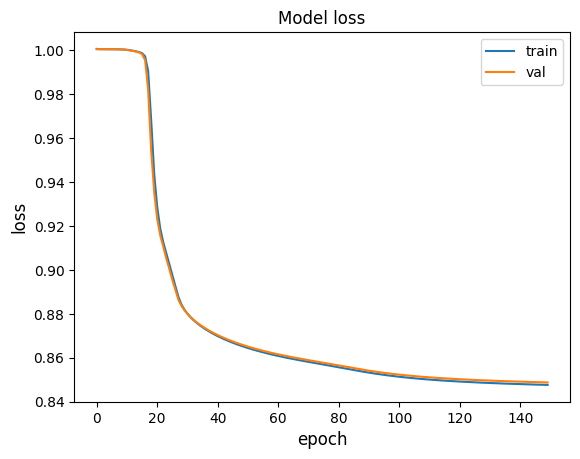

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [5]:
def make_plot_roc_curves(qcd, bsm):
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
    auc_loss = auc(fpr_loss, tpr_loss)
    qcd[::-1].sort()
    # plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
    #     linewidth=1.5)
    # plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    return auc_loss

def eval(model,x_test,bbh_pretest,sglf_pretest):
    background_test = model.predict(x_test)
    bbh_test = model.predict(bbh_pretest)
    sglf_test = model.predict(sglf_pretest)
    mse_background = np.mean((background_test - x_test)**2, axis=(1,2))
    mse_bbh = np.mean((bbh_test - bbh_pretest)**2, axis=(1,2))
    mse_sg = np.mean((sglf_test - sglf_pretest)**2, axis=(1,2))
    print('evaluating bg vs bbh')
    bbhauc = make_plot_roc_curves(mse_background, mse_bbh)
    # plt.hist(mse_background, density=True, bins=100, alpha=0.5, label='Background')
    # plt.hist(mse_bbh, density=True, bins=100, alpha=0.5, label='BBH')
    # plt.semilogy()
    # plt.legend()
    # plt.show()
    print('evaluation bg vs sg')
    sgauc = make_plot_roc_curves(mse_background, mse_sg)
    # plt.hist(mse_background, density=True, bins=100, alpha=0.5, label='Background')
    # plt.hist(mse_sg, density=True, bins=100, alpha=0.5, label='SG')
    # plt.semilogy()
    # plt.legend()
    # plt.show()
    return bbhauc,sgauc


Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_01.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
evaluating bg vs bbh
evaluation bg vs sg
Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_03.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh
evaluation bg vs sg
Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_05.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
evaluating bg vs bbh
evaluation bg vs sg
Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_07.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━

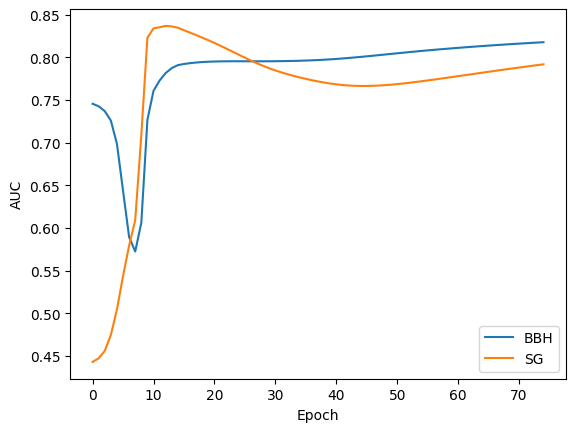

In [6]:
import re
model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_*.keras")
model_files = sorted(model_files, key=lambda x: int(re.search(r"model_epoch_(\d+).keras", x).group(1)))
bbh_auc=[]
sg_auc=[]
for model_file in model_files[::2]:
    print(f"Evaluating model: {model_file}")
    model = keras_load_model(model_file)
    bbhauc,sgauc=eval(model,x_test, bbh_test,sglf_test)
    bbh_auc.append(bbhauc)
    sg_auc.append(sgauc)

plt.plot(bbh_auc,label='BBH')
plt.plot(sg_auc,label='SG')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.show()


In [7]:
print(max(bbh_auc))
print(max(sg_auc))

0.8177730974999999
0.8368435000000001


Testing

In [8]:
# Load test data and normalize them
data = np.load('ligo_bb_final.npz')
test_data = data['data']
stds = np.std(test_data, axis=-1)[:, :, np.newaxis]
test_data = test_data/stds
test_data = np.swapaxes(test_data, 1, 2)
data_label = data['ids']
indices1 = np.where(data_label == 1)[0]
indices0 = np.where(data_label == 0)[0]
background_test_data = test_data[indices0]
signal_test_data = test_data[indices1]

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_01.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


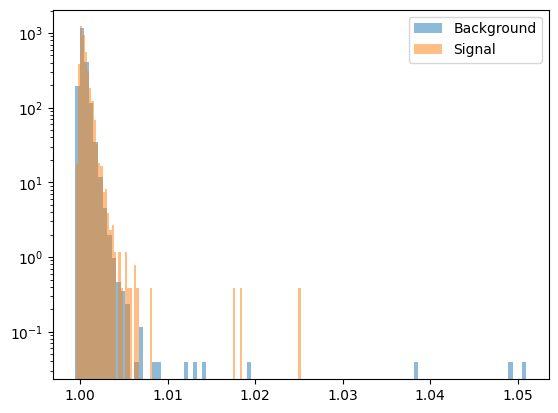

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_03.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


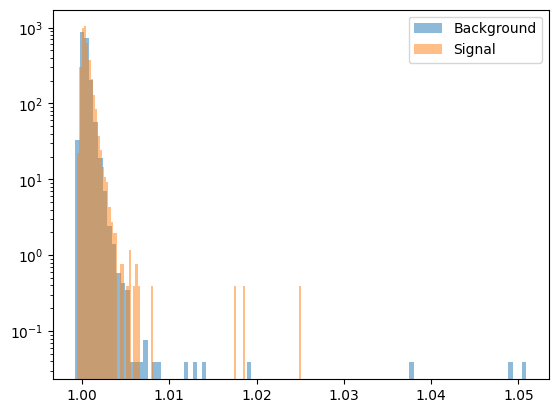

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_05.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


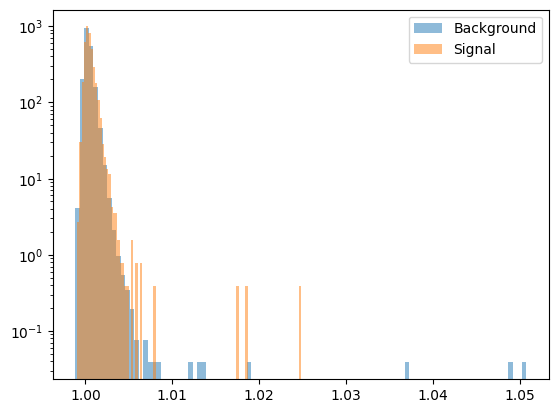

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_07.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


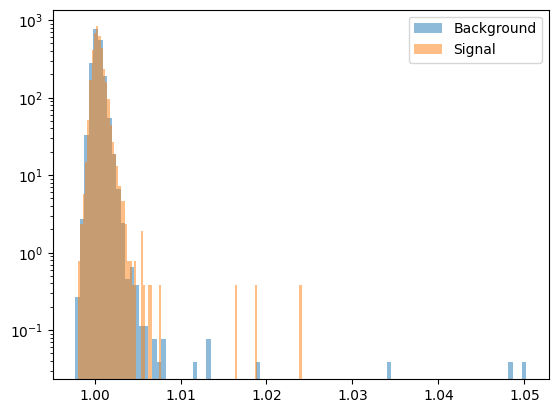

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_09.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


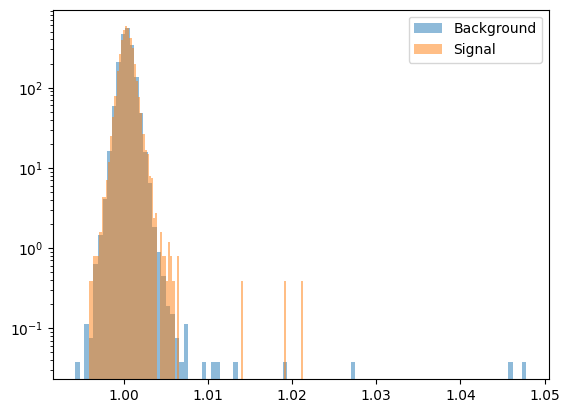

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_11.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


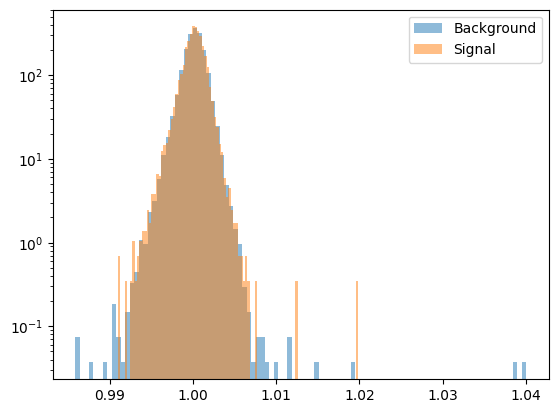

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_13.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


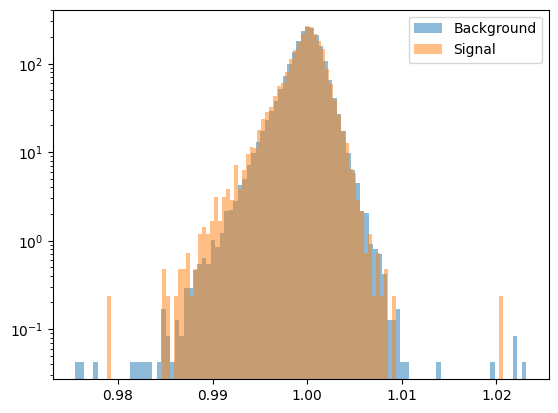

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_15.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


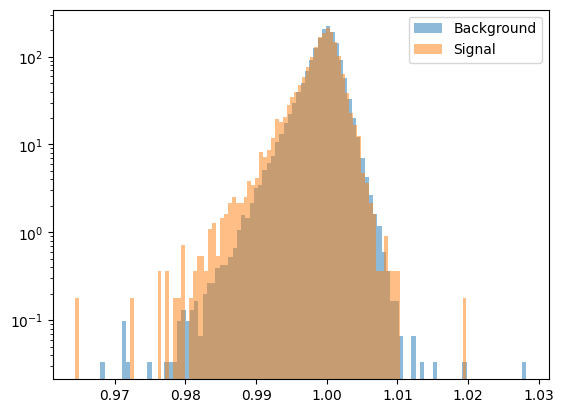

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_17.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


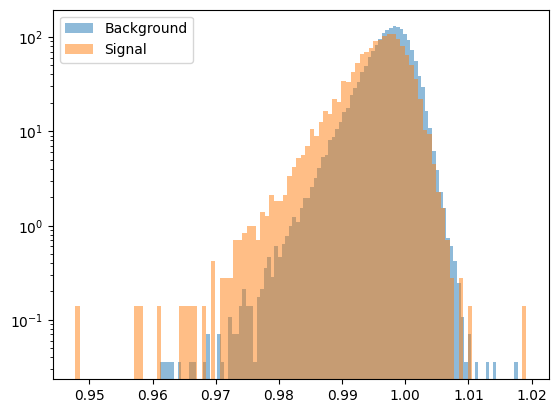

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_19.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


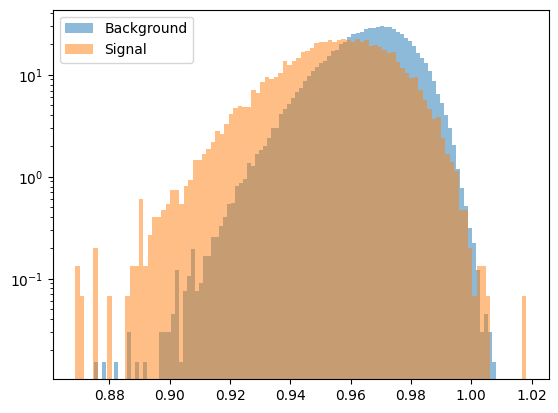

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_21.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


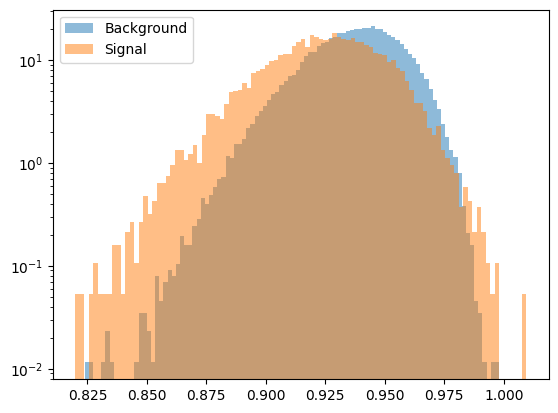

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_23.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


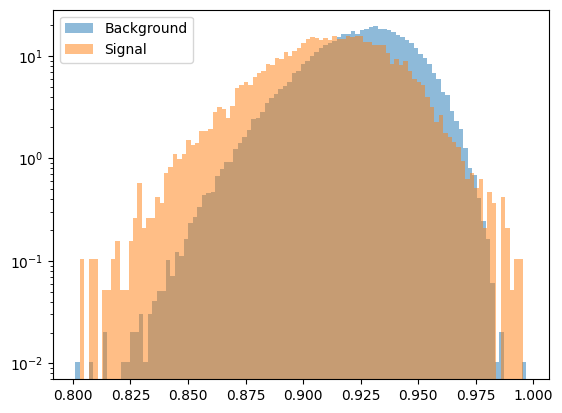

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_25.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


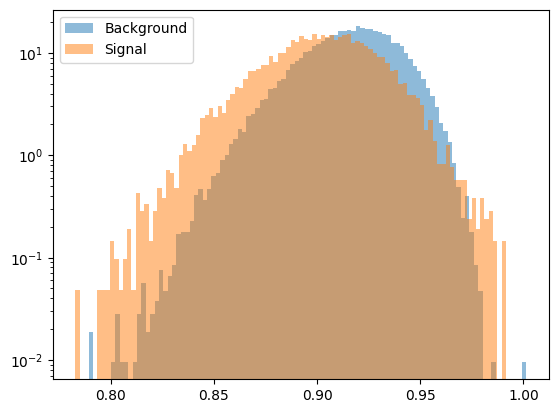

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_27.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


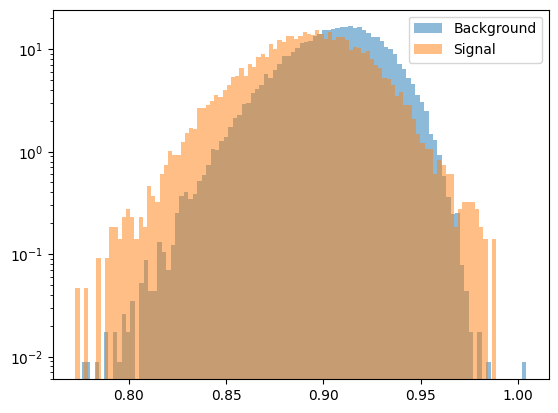

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_29.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


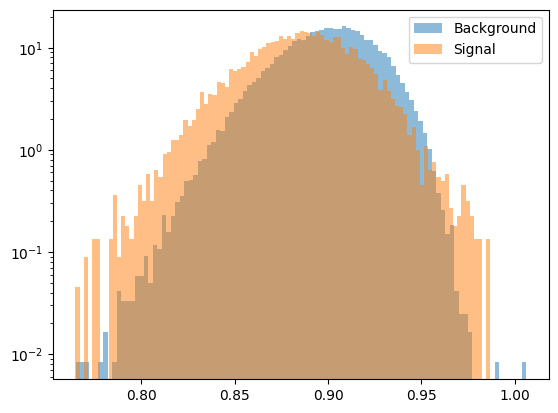

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_31.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


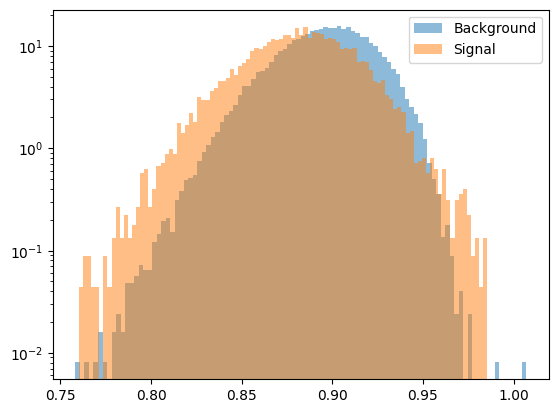

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_33.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


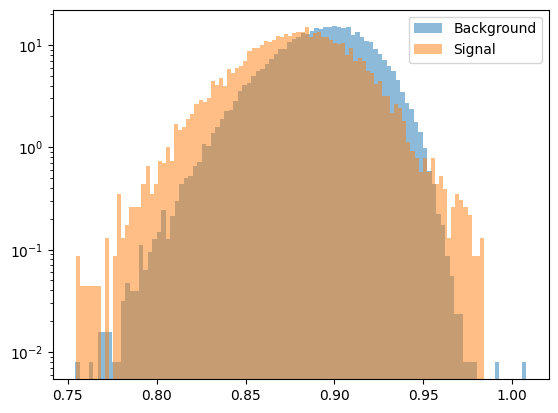

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_35.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


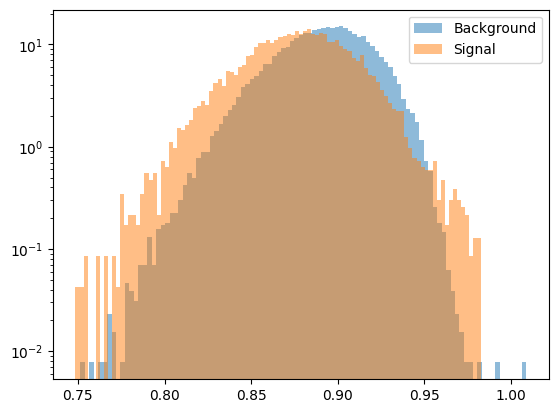

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_37.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


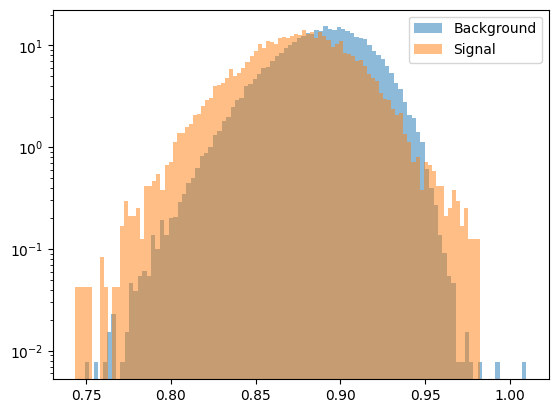

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_39.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


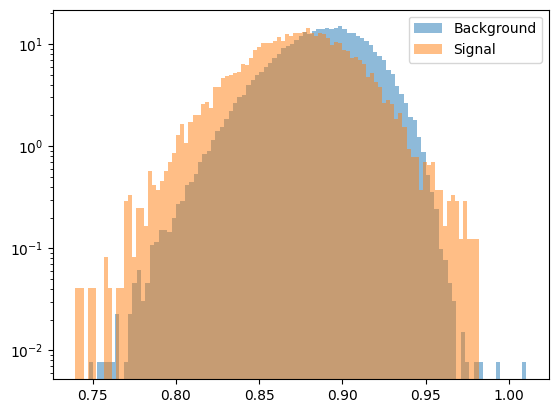

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_41.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


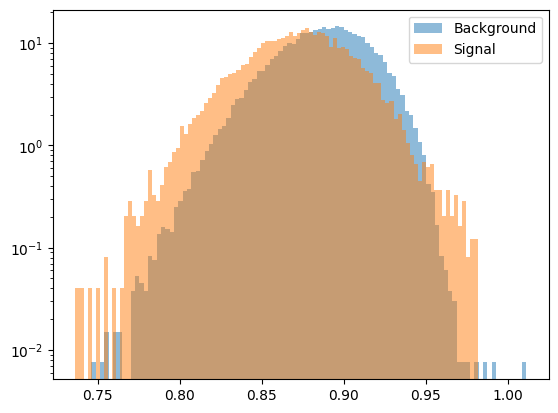

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_43.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


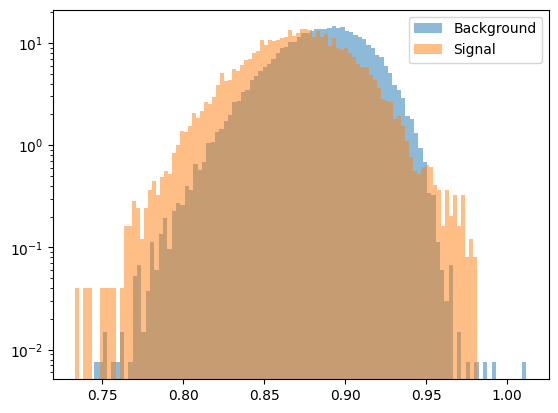

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_45.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


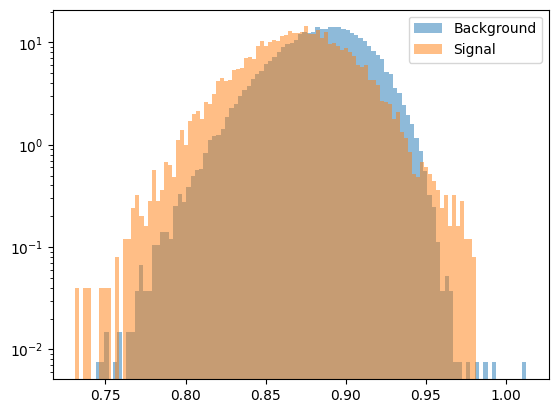

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_47.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


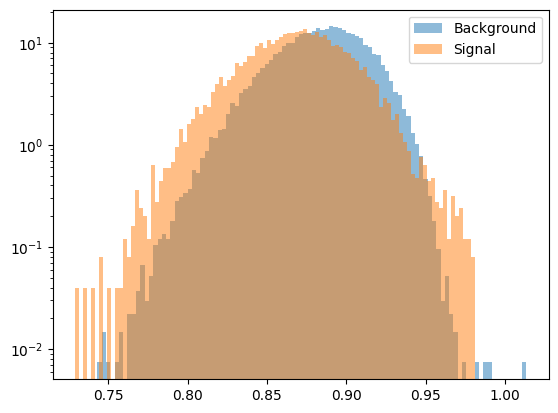

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_49.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


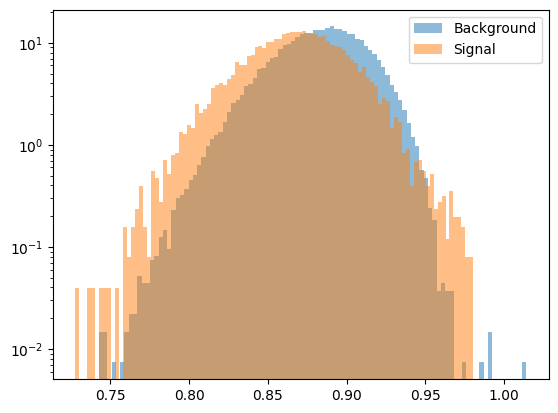

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_51.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


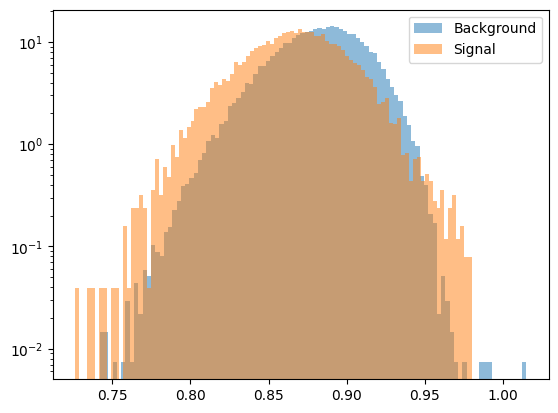

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_53.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


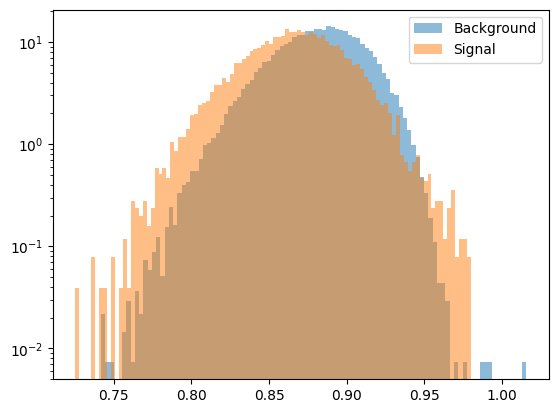

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_55.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


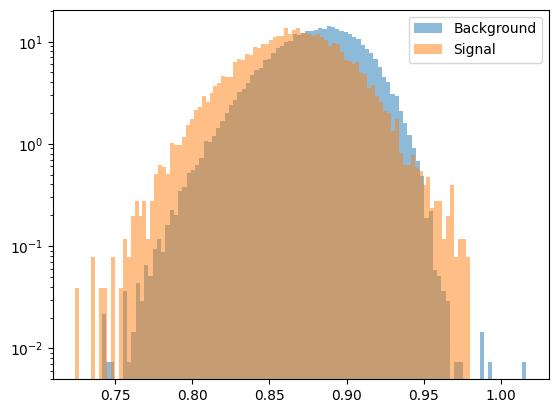

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_57.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


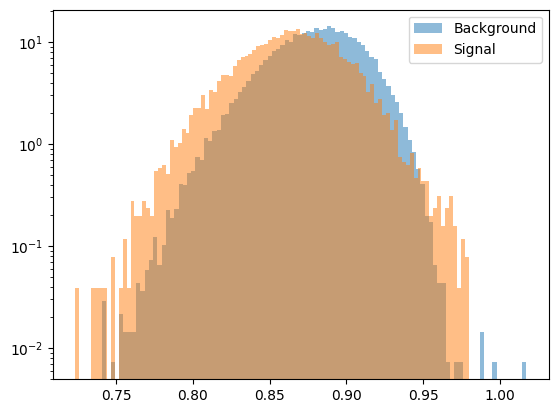

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_59.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


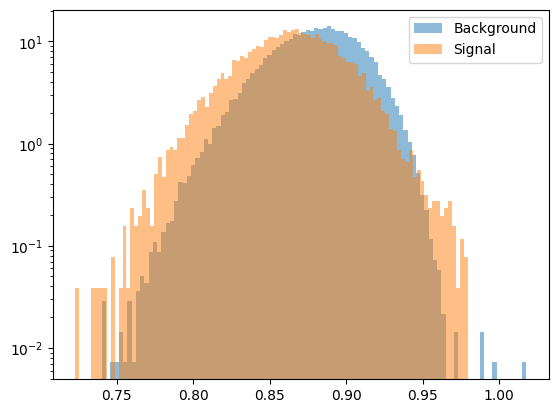

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_61.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


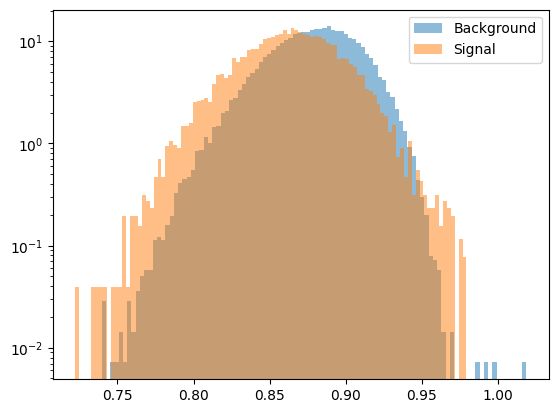

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_63.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


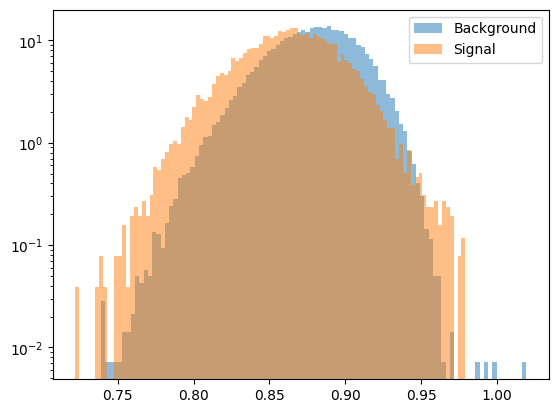

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_65.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


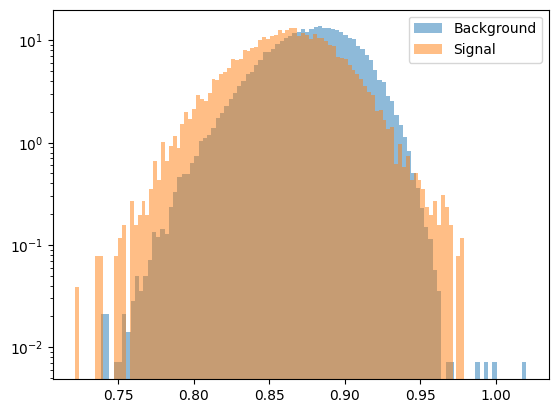

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_67.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


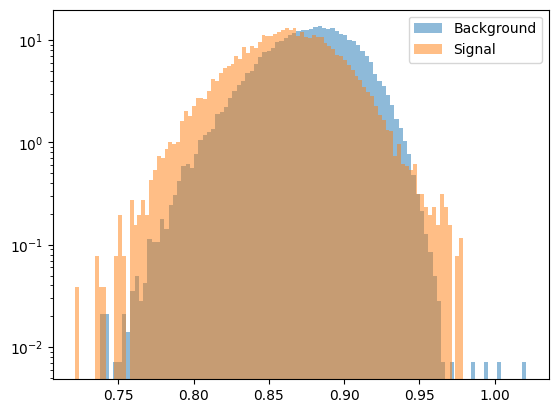

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_69.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


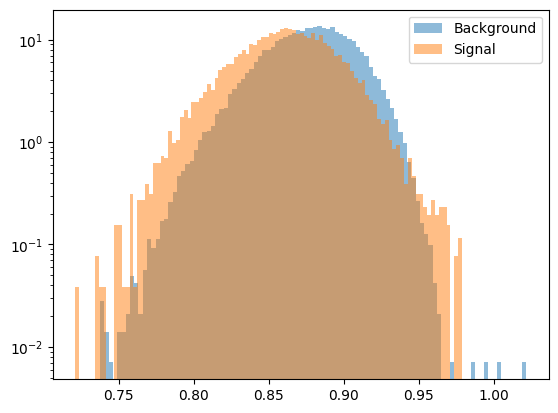

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_71.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


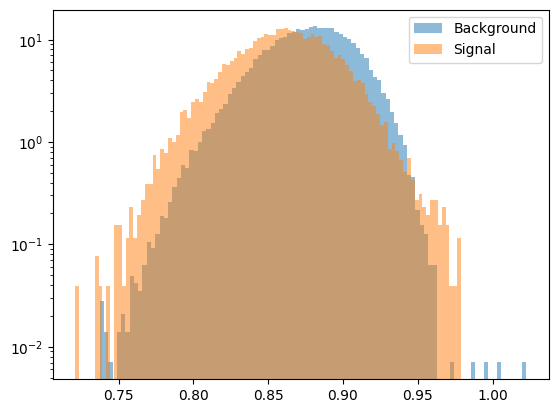

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_73.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


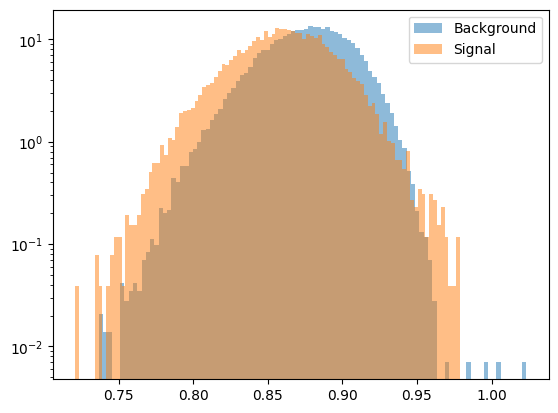

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_75.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


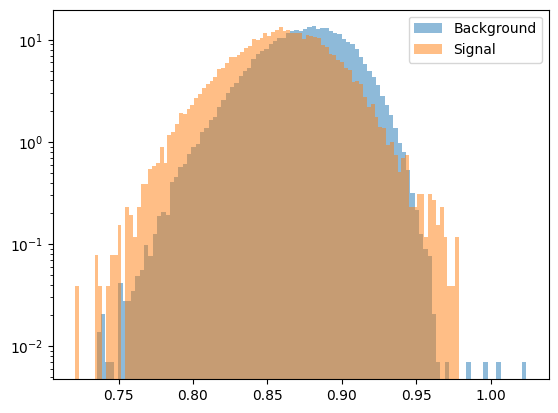

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_77.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


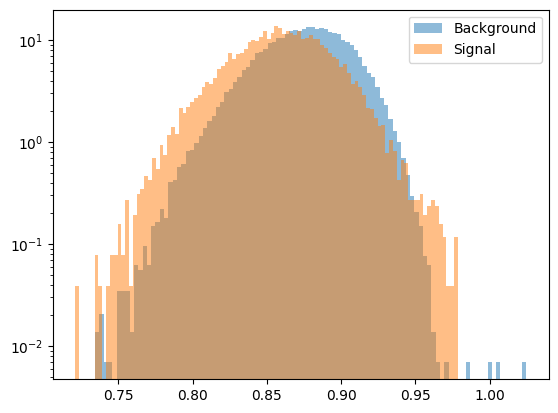

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_79.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


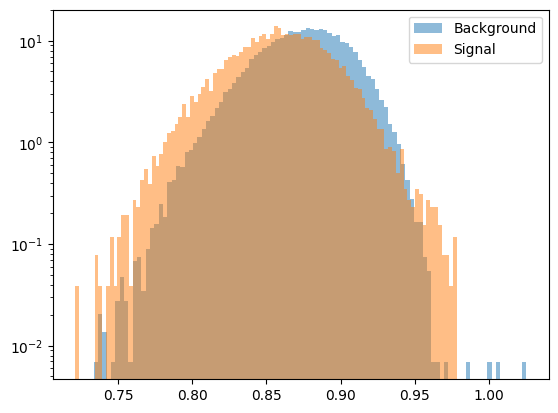

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_81.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


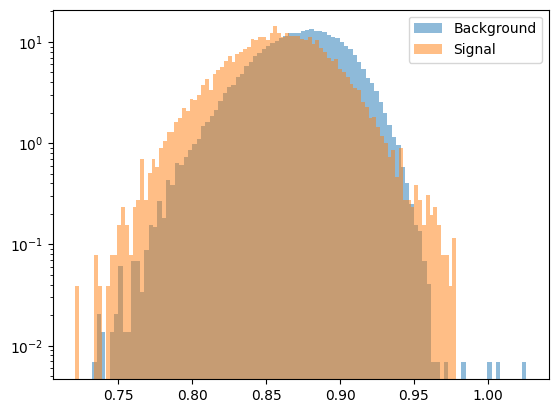

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_83.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


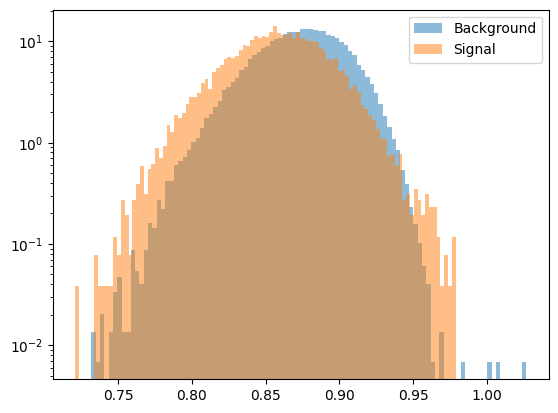

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_85.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


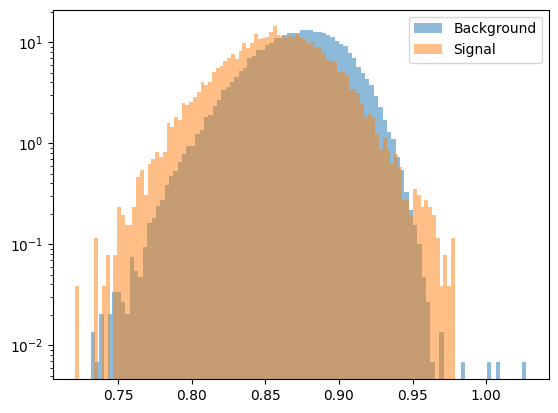

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_87.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


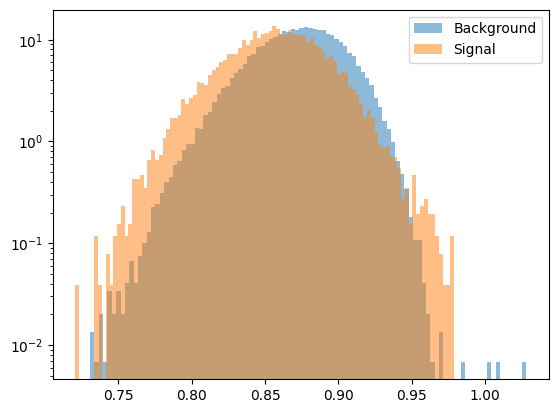

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_89.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


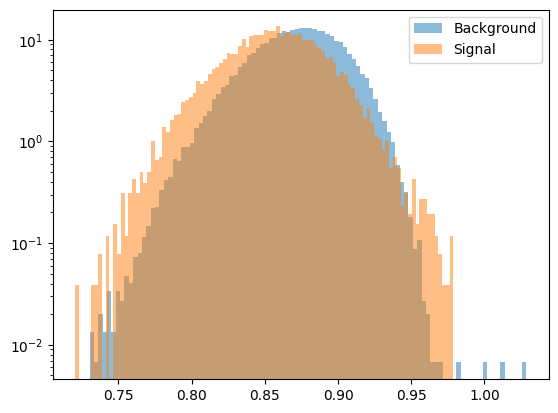

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_91.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


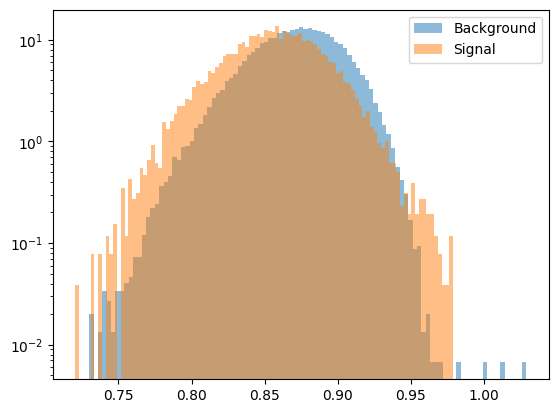

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_93.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


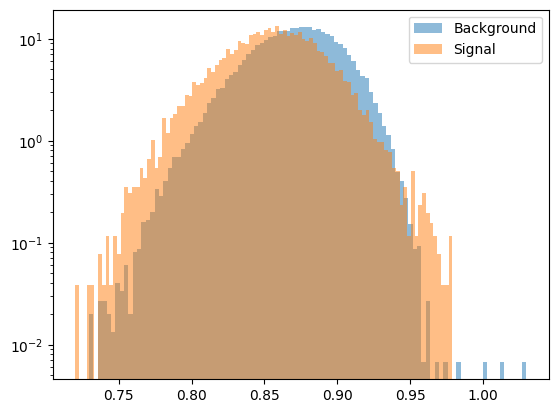

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_95.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


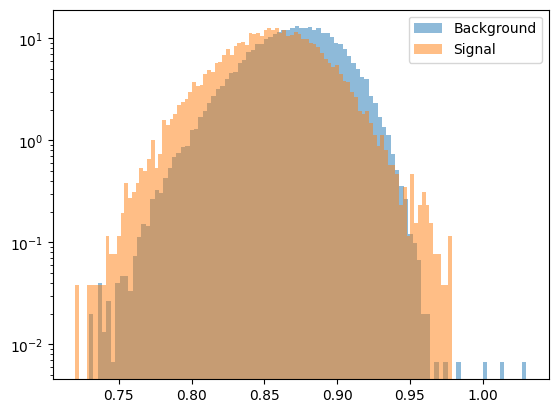

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_97.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


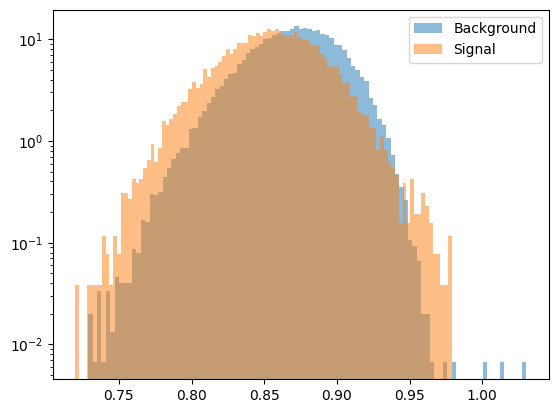

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_99.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


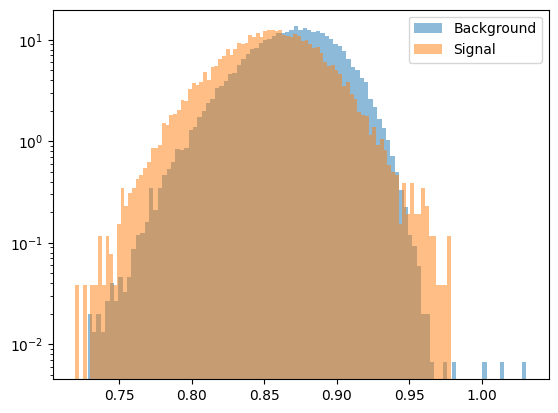

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_101.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


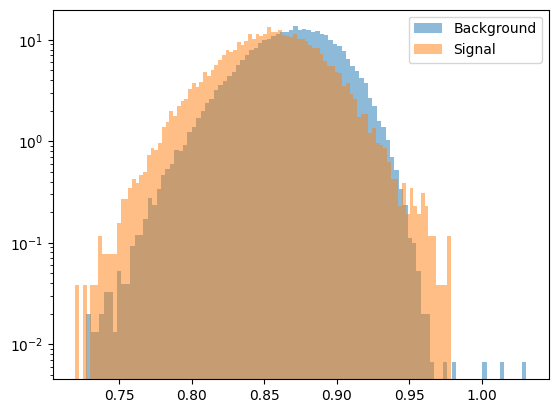

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_103.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


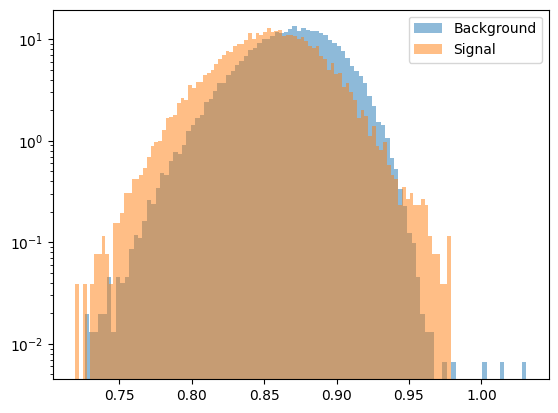

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_105.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


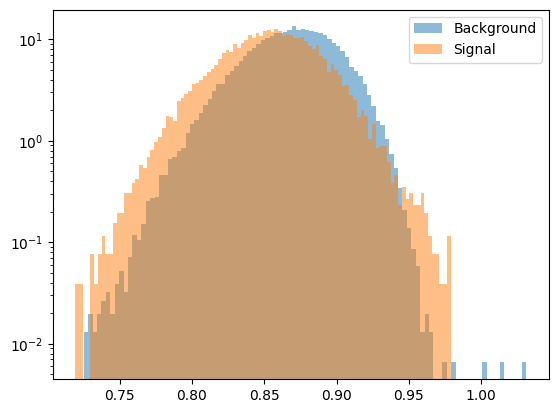

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_107.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


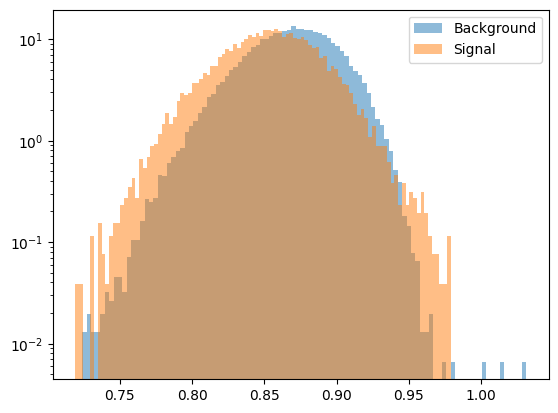

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_109.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


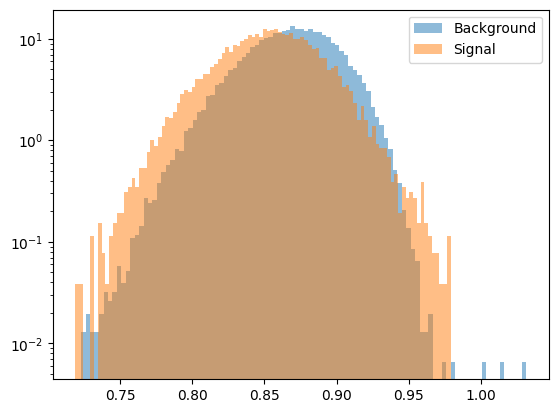

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_111.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


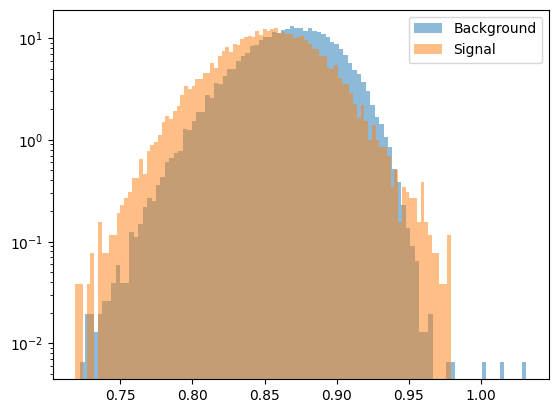

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_113.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


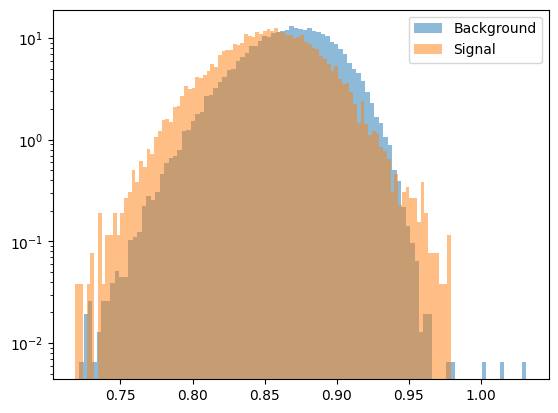

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_115.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


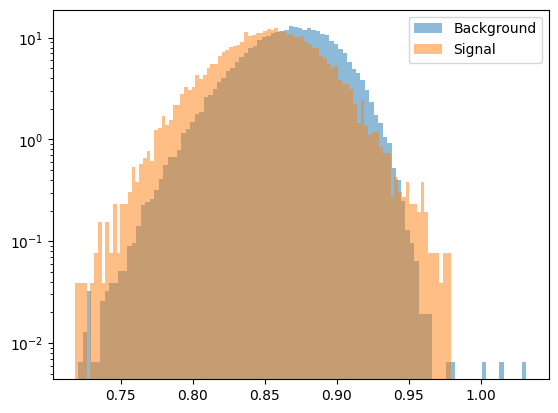

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_117.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


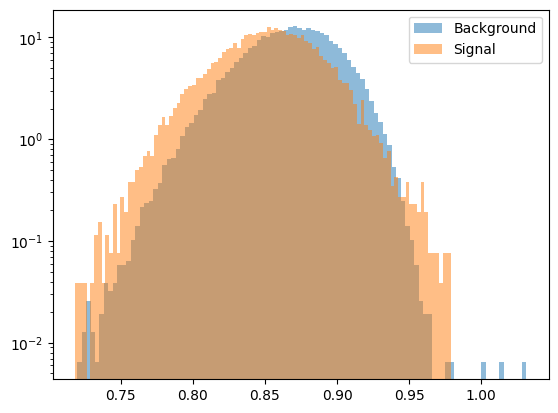

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_119.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


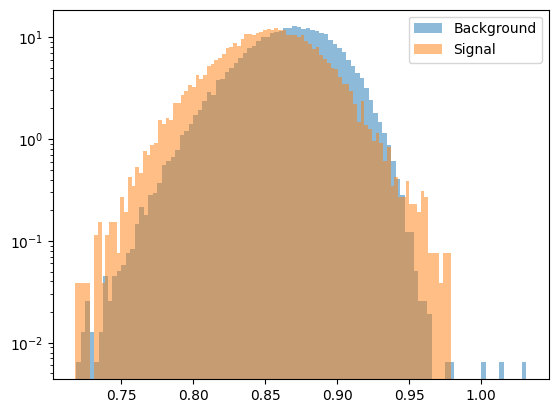

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_121.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


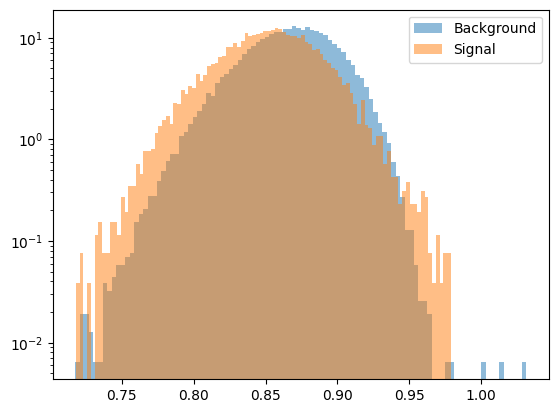

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_123.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


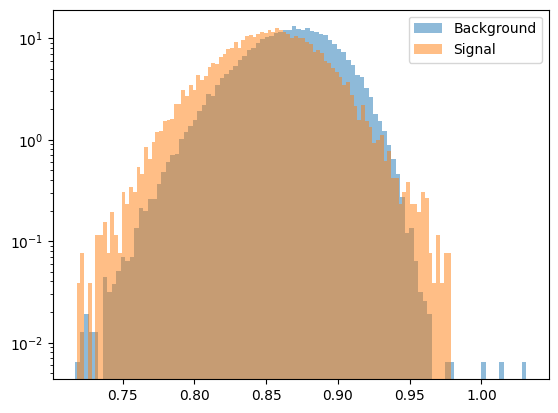

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_125.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


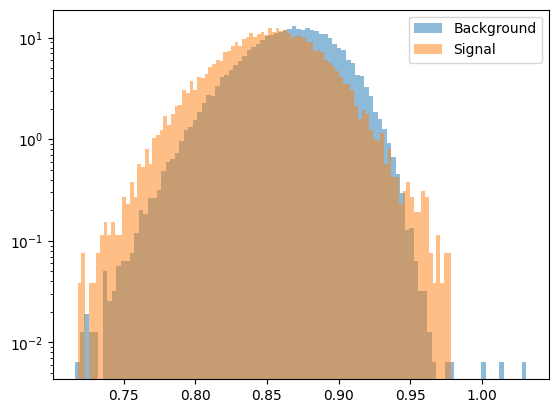

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_127.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


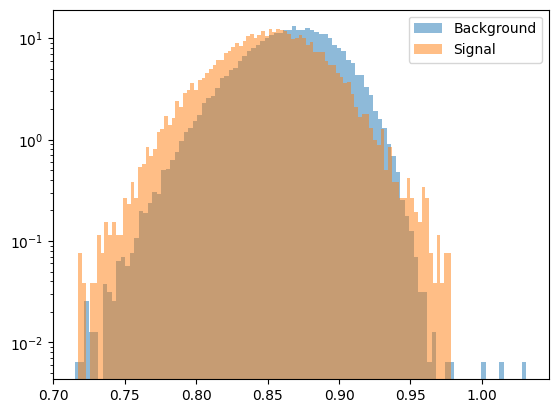

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_129.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


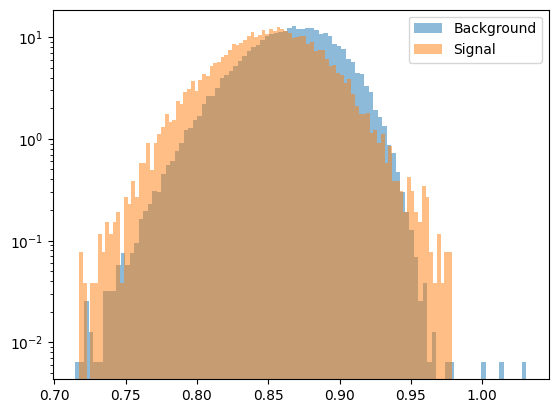

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_131.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


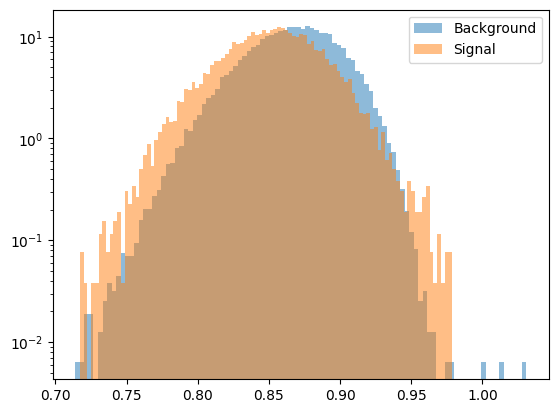

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_133.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


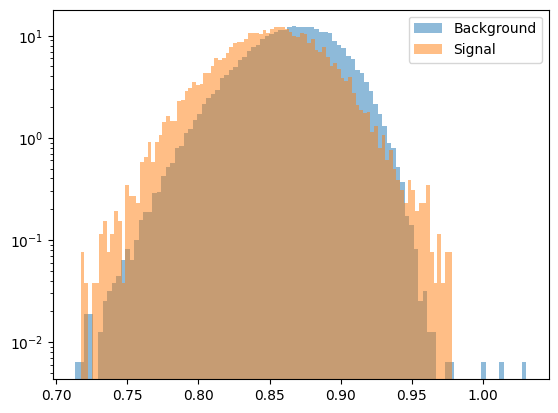

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_135.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


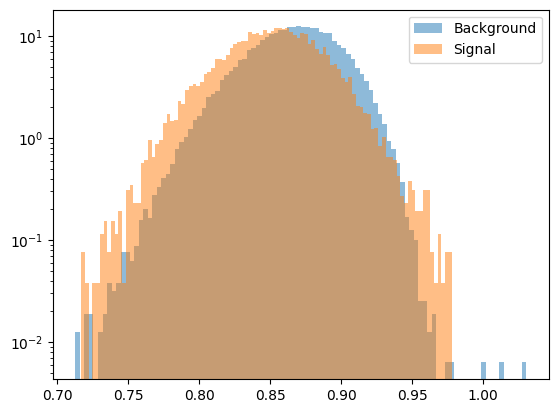

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_137.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


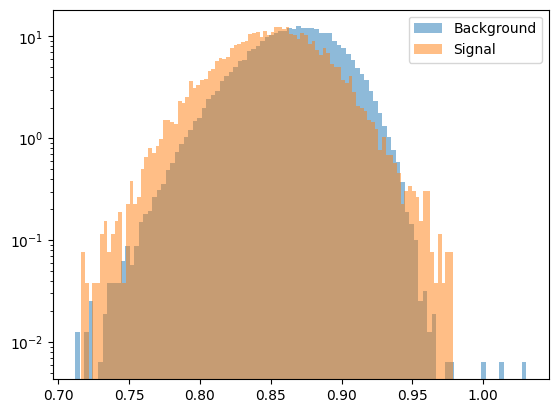

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_139.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


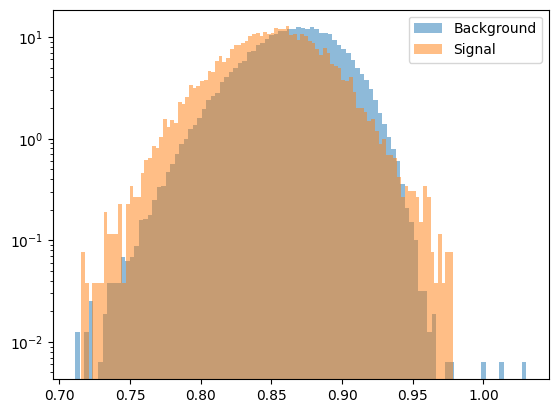

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_141.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


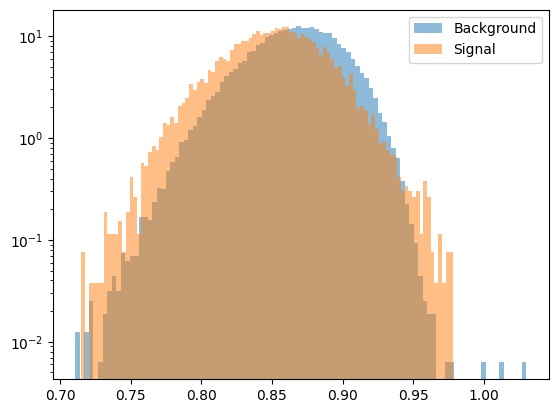

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_143.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


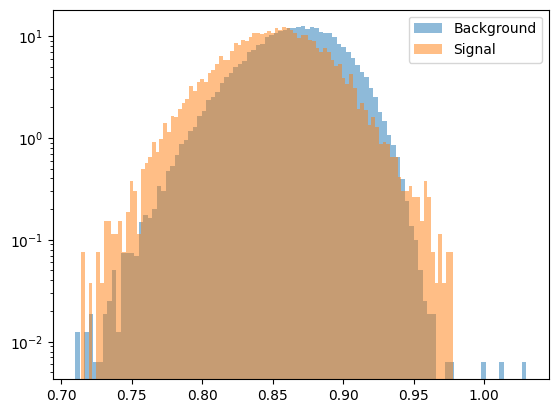

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_145.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


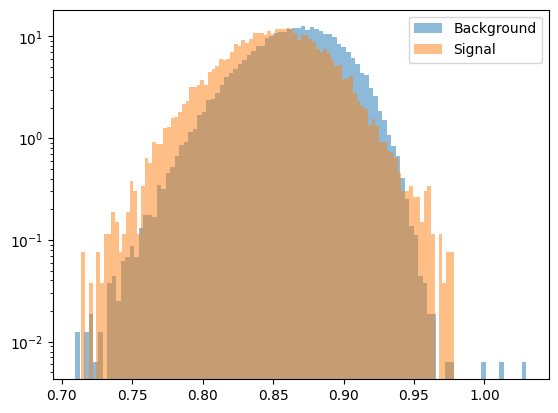

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_147.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


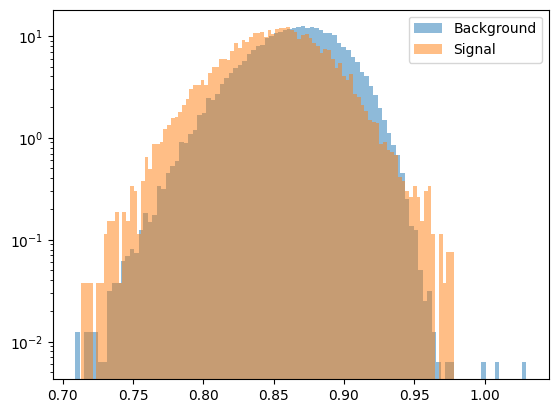

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_149.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


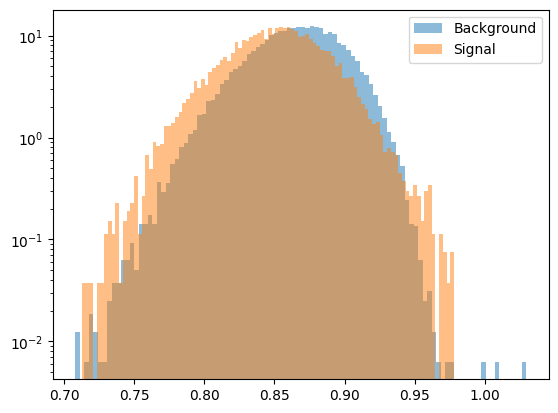

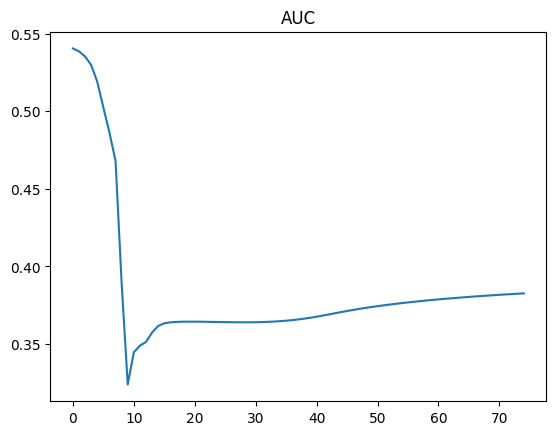

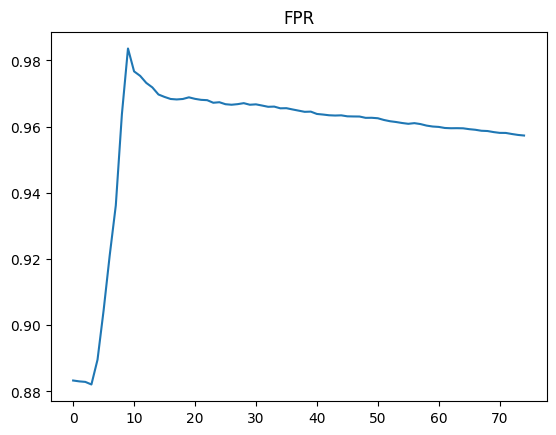

In [10]:
# Load model
model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_*.keras")
model_files = sorted(model_files, key=lambda x: int(re.search(r"model_epoch_(\d+).keras", x).group(1)))
from sklearn.metrics import roc_curve, auc
def eval_test(model,background_test_data,signal_test_data):
  bg_test = model.predict(background_test_data)
  sg_test = model.predict(signal_test_data)
  mse_bg = np.mean((bg_test - background_test_data)**2, axis=(1,2))
  mse_sg = np.mean((sg_test - signal_test_data)**2, axis=(1,2))
  pred_val = np.concatenate((mse_sg, mse_bg))
  true_val = np.concatenate((np.ones(mse_sg.shape[0]), np.zeros(mse_bg.shape[0])))
  fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
  AUC = auc(fpr_loss, tpr_loss)
  idx = np.argmin(np.abs(tpr_loss - 0.90))    #nearest value's index at 0.9 TPR
  desired_fpr = fpr_loss[idx]    #FPR at 0.9 TPR
  return AUC, desired_fpr, mse_bg, mse_sg

AUC_test=[]
FPR_test = []

for model_file in model_files[::2]:
    print(f"Evaluating model: {model_file}")
    model = keras_load_model(model_file)
    AUC_, FPR_, mse_bg, mse_sg = eval_test(model,background_test_data,signal_test_data)
    plt.hist(mse_bg, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_sg, density=True, bins=100, alpha=0.5, label='Signal')
    plt.semilogy()
    plt.legend()
    plt.show()
    AUC_test.append(AUC_)
    FPR_test.append(FPR_)
plt.plot(AUC_test)
plt.title('AUC')
plt.show()
plt.plot(FPR_test)
plt.title('FPR')
plt.show()

In [11]:
max(AUC_test),min(FPR_test)

(np.float64(0.54050404), np.float64(0.8821))